# Working with GeoPandas and PySAL

We've worked -- and will continue to work -- a lot with pandas, but by default pandas doesn't help us much when want to start working with explicitly geographical data. Ways of working _computationally_ with things like distance and location are increasingly important not only to geographers, but also to data scientists, and this is where we start to move away from purely aspatial statistical analysis into the foundations of a more _geographic_ data science.

There are a huge number of modules in Python designed to help you work with geodata, but we are going to focus on the two most important higher-level libraries (since they also provide 'wrappers' around some of the lower-level libraries):

1. [GeoPandas](http://geopandas.org/) -- which offers a pandas-like interface to working with geodata. Think of this as your tool for basic data manipulation and transformation, much like pandas. You will almost certainly want to [bookmark the documentation](http://geopandas.org/user.html#geodataframe).
2. [PySAL](http://pysal.readthedocs.io/en/latest/) -- the Python Spatial Analysis Library  provides the spatial analytic functions that we'll need for everything from classification, clustering and point-pattern analysis to autocorrelation-based tools.
3. There is some overlap between the two libraries: both can do plotting but, for reasons we'll see later, we'll normally do this in PySAL and both can do classification (remember, we did _quantiles_ with pandas!) but (again), for reasons we'll see later, we'll often do this in PySAL from here on out.

PySAL is complicated enough that the best way to understand how it fits together is to use an image:

![PySAL Logo](http://darribas.org/gds_scipy16/content/figs/pysal.png)

We're going to concentrate primarily on the ESDA (Exploratory _Spatial_ Data Analysis) and Weights components of PySAL in this module, but you should know about the other bits!

## A (Semi-Brief) Discourse on Families & Inheritance

GeoPandas objects are deliberately designed to resemble Pandas objects. There are two good reasons for this: 

1. Since Pandas is well-known, this makes it easier to learn how to use GeoPandas.
2. GeoPandas _inherits_ functionality from Pandas. 

The concept of **inheritance** is something we've held off from mentioning until now, but it's definitely worth understanding if you are serious about learning how to code. In effect, geopandas '_imports_' pandas and then _extends_ it so that the more basic class (pandas in this case) learns how to work with geodata... pandas doesn't know how to read shapefiles or make maps, but geopandas does. Same for GeoJSON.

### The 'Tree of Life'

Here's a simple way to think about inheritance: think of the 'evolutionary trees' you might have seen charting the evolution of organisms over time. At the bottom of the tree is the single-celled animal, and at the other end are humans, whales, wildebeest, etc. We all _inherit_ some basic functionality from that original, simple cell. In between us and that primitive, however, are a whole series of branches: different bits of the tree evolved in different directions and developed different 'functionality'. Some of us have bones. Some have  cartilege. Some are vegetarian, and some are carnivorous. And so on. When you get to the primates we all share certain common 'features' (binocular vision, grasping hands, etc.), but we are _still_ more similar to gorillas than we are to macaques. So gorillas and humans _extend_ the primitive 'primate functionality' with some bonus features (bigger brains, greater strength, etc.) that are useful, while macaques extend it with a slightly different set of features (tails, etc.).

![Tree of Life](http://palaeos.com/systematics/tree/images/treeolif.jpg)

### The 'Tree of Classes'

Inheritance in code works in a similar way: *all* Python classes (lists, pandas, plots, etc.) inherit their most basic functionality from a single primitive 'object' class that itself does very little except to provide a template for what an object should look like. As you move along the inheritance tree you will find more and more complex objects with increasingly advanced features: GeoPandas inherits from Pandas, Bokeh and Seaborn inherit from matplotlib, etc. 

I can't find an image of Python base class inheritance, but I've found an equally useful example of how _anything_ can be modelled using this 'family tree' approach... consider the following:

![Vehicle Inheritance](http://www.mkonar.org/dogus/wiki/lib/exe/fetch.php/python/vehicle.png?w=750&tok=4c7ed7)

If we were trying to implement a vehicle registration scheme in Python, we would want to start with the most basic category of all: _vehicle_. The vehicle class itself might not do much, but it gives us a template for _all_ vehicles (e.g. it must be registered, it must have a unique license number, etc.). We then _extend_ the functionality of this 'base class' with three intermediate classes: two-wheeled vehicles, cars, and trucks. These, in turn, lead to eight actual vehicle types. These might have _additional_ functionality: a bus might need have a passenger capacity associated with it, while a covnertible might need to be hard- or soft-top. All of this could be expressed in Python as:

```python
class vehicle(object): # Inherit from base class
    def __init__(self):
        ... do something ...

class car(vehicle): # Inherit from vehicle
    def __init__(self):
        ... do other stuff ...

class sedan(car): # Inherit from car
    def __init__(self):
        ... do more stuff ...
```

This way, when we create a new `sedan`, it automatically 'knows' about vehicles and cars, and can make use of functions like `set_unique_id(<identification>)` even if that function is _only_ specified in the base vehicle class! The thing to remember is that programmers are _lazy_: if they can avoid reinventing the wheel, they will. Object-Oriented Programming using inheritance is a good example of _constructive_ laziness: it saves us having to constantly copy and paste code (for registering a new vehicle or reading in a CSV file) from one class to the next since we can just import it and extent it! 

Inheritance also means that you can always use an instance of a 'more evolved' class in place of one of its ancestors: simplifying things a _bit_, a sedan can automatically do anything that a car can do and, by extension, anything that a vehicle can do. Similarly, since geopandas inherits from pandas if you need to use a geopandas object _as if_ it's a pandas object then that will work! So everything you learned last term for pandas can still be used in geopandas. Kind of cool, right?

Finally, looking back at our example above: what about unicycles? Or tracked vehicles like a tank? This is where _design_ comes into the picture: when we're planning out a family tree for our work we need to be careful about what goes where. And there isn't always a single right answer: perhaps we should distinguish between pedal-powered and motor-powered (in which case unicycles, bicycles and tricycles all belong in the same family)? Or perhaps we need to distinguish between wheeled and tracked (in which case we're missing a pair of classes [wheeled, tracked] between 'vehicle' and 'two-wheel, car, truck')? These choices are tremendously important but often very hard to get right.

OK, that's enough programming theory, let's see this in action...

## Reading a Shapefile with GeoPandas

Similar to what we did last week, I want you to start by creating a map of the world coloured according to population. But this week we're going to do it in GeoPandas instead of Folium.

First, you will need to download the zipped World Borders shapefile from [Thematic Mapping](http://thematicmapping.org/downloads/TM_WORLD_BORDERS_SIMPL-0.3.zip) and save this to your 'shapes' or 'data' folder since GeoPandas can't read 'remote' files. You will also need to unzip the file so that Geopandas can read it.

_Remember:_ as long as you have saved the file to somewhere accessible to Jupyter (i.e. a directory _beneath_ the current one where you are working) then you can find out the 'path' to a file by switching to the 'Home' tab in your browser and navigating to the file. You can _also_ find out where the current Notebook is running like this:

In [1]:
!pwd # !cd on Windows

/Users/jreades/Documents/github/Spatial Analysis


In other words, depending on your setup you might need to tweak the path in the code below to get your own code working...

In [2]:
import os
import pandas as pd
import geopandas as gpd

# Make numeric display a bit easier
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))

# Make sure output is into notebook
%matplotlib inline

gdf = gpd.read_file( 
    os.path.join('shapes', 'TM_WORLD_BORDERS_SIMPL-0.3', 'TM_WORLD_BORDERS_SIMPL-0.3.shp') 
)

gdf.head(3)

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
0,44,AC,AG,ATG,17,-62,Antigua and Barbuda,83039,19,29,28,(POLYGON ((-61.68666800000003 17.0244410000001...
1,238174,AG,DZ,DZA,28,3,Algeria,32854159,2,15,12,"POLYGON ((2.963610000000017 36.802216, 4.78583..."
2,8260,AJ,AZ,AZE,40,47,Azerbaijan,8352021,142,145,31,(POLYGON ((45.08332252502441 39.76804542541504...


So far so good! Notice that even the output of the `head` function is the same as from pandas. The only obvious difference so far is that `geometry` column on the right-hand side which doesn't contain numbers or strings, but `POLYGON`s. In a nutshell, aside from the ability to read geodata directly (we just loaded a shapefile using only code!) this geometry column is the other marker of a big step from pandas to geopandas.

But let's dig a little deeper:

In [3]:
print("Let's look at inheritance: ")

if isinstance(gdf, gpd.GeoDataFrame): # Is gdf a GeoDataFrame object?
    print("\tI'm a geopandas data frame!")

if isinstance(gdf, pd.DataFrame): # Is gdf *also* a DataFrame object?
    print("\tI'm also a pandas data frame!")

print("-" * 50)

print("Let's look at some pandas methods we know: ") # See inheritance in action

print("Using the 'sample()' method: ")
print(gdf.sample(3))
print("-" * 50)

print("What the POP2005 column type: ")
print('\tNAME type: ' + str(type(gdf.POP2005)))
print("-" * 50)

print("Describe the column: ")
print(gdf.POP2005.describe())
print("-" * 50)

print("Let's look at some new methods from geopandas: ") # Here's stuff pandas can't do

print("What's the geometry column type: ")
print('\tGeometry type: ' + str(type(gdf.geometry)))
print("-" * 50)

# The next line is very slow, don't run it:
# print(gdf.geometry.describe())
# print("-" * 50)

print("Is there projection information: ")
print('\tCRS: ' + str(gdf.crs))
print("-" * 50)

print("Help with the centroid method of the GeoSeries (geometry) column: ")
help(gdf.geometry.centroid)

Let's look at inheritance: 
	I'm a geopandas data frame!
	I'm also a pandas data frame!
--------------------------------------------------
Let's look at some pandas methods we know: 
Using the 'sample()' method: 
      AREA FIPS ISO2 ISO3  LAT  LON      NAME   POP2005  REGION  SUBREGION  \
17   65755   BM   MM  MMR   22   96     Burma  47967266     142         35   
223  38685   ZI   ZW  ZWE  -19   30  Zimbabwe  13119679       2         14   
194  51089   TH   TH  THA   16  101  Thailand  63002911     142         35   

      UN                                           geometry  
17   104  (POLYGON ((98.03581200000011 9.786385999999979...  
223  716  POLYGON ((32.987808 -17.26500299999995, 33.073...  
194  764  (POLYGON ((99.21916200000007 6.532499000000001...  
--------------------------------------------------
What the POP2005 column type: 
	NAME type: <class 'pandas.core.series.Series'>
--------------------------------------------------
Describe the column: 
count             246
m

This next command may take a while to complete -- the geopandas developers know that their mapping code is sloooooooooow, and that's one of the reasons we're going to use PySAL for most of our work. But 'watch this space' since they are working on it and there may even be an update this year that addresses the single biggest complaint that people have about geopandas.

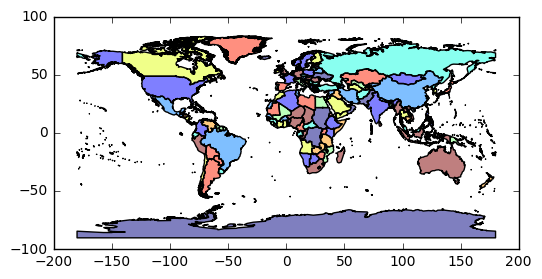

In [4]:
gdf.plot()

Some questions for you:
1. What type of data structure is the CRS attribute of the geopandas data frame?
2. How would you confirm this?
3. Can you figure out how to reproject the data using the geopandas documentation?
4. What is the data structure of the geometry column (broadly)?
5. Are there any differences between what a similar pandas data frame would give you if you ran any of the non-geographic commands?

## Working with the AirBnB Data

That should have given you a sense of some parallels/differences between Folium and Geopandas: Folium is more of a web-based, interactive visualisation library, while Geopandas is really built around large data sets and data analytics. We're now going to move into areas where Folium would have a lot of trouble keeping up: a data set scraped from AirBnB in Feburary of 2016. 

### Randomness & Reproducibility

In fact, it turns out that rapid visualisation of the _full_ AirBnB data set using Geopandas/PySAL is hard: there's simply so much of it that visualisation is slow unless you're in a dedicated environment such as QGIS. So, for the _exploratory_ part of our work we'll want to work with a _sample_ -- but what happens if every time we take a sample we get a _different_ sample? That obviously makes things a bit harder, it would be handy if we could get the _same_ random sample every time _while_ we're doing our testing and development before expanding to the full data set.

That's where `random.seed` comes in: by setting a seed we ensure that any process based on a random/random sampling process will be reproducible. In other words, we'll get the _same_ random sample each time. To under why this happens you'd need to read up on pseudo-randomness and computers but that's not really relevant here.

In [17]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd

import random 
random.seed(123456789) # For reproducibility

%matplotlib inline

df = pd.read_csv(os.path.join('data','airbnb-2016-Feb','listings-summary.csv.gz'))

print("Full data set shape is: " + ', '.join(str(i) for i in df.shape))

Full data set shape is: 33715, 16


In [13]:
df.columns

Index([u'id', u'name', u'host_id', u'host_name', u'neighbourhood_group',
       u'neighbourhood', u'latitude', u'longitude', u'room_type', u'price',
       u'minimum_nights', u'number_of_reviews', u'last_review',
       u'reviews_per_month', u'calculated_host_listings_count',
       u'availability_365'],
      dtype='object')

In [14]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,5910748,The Beach House in the Suburbs,30698497,Mike,nan,Kingston upon Thames,51,-0,Private room,45,2,9,2015-11-07,1,1,310
1,8950456,Clean nice apartment in Kingston,1343541,Leon,nan,Kingston upon Thames,51,-0,Entire home/apt,60,4,2,2015-12-12,1,1,52


In [18]:
sample = df.sample(frac=0.1)
print("Sample data set shape is: " + ', '.join(str(i) for i in sample.shape))
sample.describe()

Sample data set shape is: 3372, 16


,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,"3,372","3,372",0,"3,372","3,372","3,372","3,372","3,372","2,432","3,372","3,372"
mean,"5,950,775","18,270,155",nan,52,-0,95,3,12,1,5,211
std,"3,171,528","15,793,651",nan,0,0,76,5,24,1,12,151
min,"46,825","11,334",nan,51,-0,12,1,0,0,1,0
25%,"3,408,828","4,108,021",nan,51,-0,45,1,0,0,1,32
50%,"6,430,306","13,747,422",nan,52,-0,75,2,3,1,1,280
75%,"8,715,006","30,426,533",nan,52,-0,120,3,12,2,2,360
max,"10,990,844","56,974,784",nan,52,0,998,150,278,10,94,365


You can _always_ do a 'quick and dirty' scatter plot to see if the data seems vaguely sensible -- it's obviously limited as a geo-visualisation but it can give you an _idea_ of whether or not you've done the right thing with your data. For example...

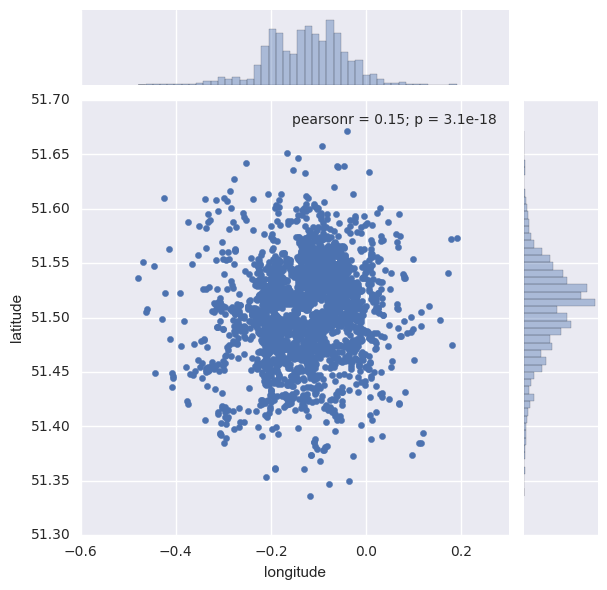

In [19]:
#help(sns.jointplot)
sns.jointplot(x="longitude", y="latitude", data=sample)

You'll notice that this 'map' isn't particularly good, but it does tell us that the longitude and latitude values are reasonable: you'd expect to find more AirBnB listings towards the middle of the city and there's a _hint_ of the Thames and the Lee Valley in there (though this is a bit of a stretch). To actually _map_ the data we'll need to be a little more rigorous... 

Let's step through what's going on below:
1. We need to import the `Point` class so that we move from separate x and y columns to a single 'point' that Geopandas can work with.
2. We then 'zip' up the x and y (i.e. lat and long) into pairs -- think of this as a simple way to pair _each_ x and y based on their row position and this allows us to move from separate columns to actual points.
3. The next step is to tell Geopandas what projection our data is in -- raw lat and long are _usually_ recorded in WGS84 which has the EPSG identifier 4326 (_i.e._ epsg:4326).
4. You'll notice that to create a new `GeoDataFrame` we do so _slightly_ differently from how we created a new `DataFrame` last term: we pass in the existing `pandas` data frame (`sample`), the CRS (projection), and finally the `geometry` that we created from the `zip` process.
5. The last step is to reproject the geometry into OSGB (Ordnance Survey GB) which has the EPSG identifier 27700. 

You can see the results of this step in the final step where we print out the first 3 rows of the reprojected data: notice that the point coordinates are no longer in lat/long!

Some of this _might_ seem a little tedious, but it's incredibly useful to be able to automate this process: we can reproject a whole series of shapefiles (e.g. every single file in a directory!), we can convert CSV files into shapes that load automatically into QGIS instead of having to do this process manually...

In [42]:
from shapely.geometry import Point
# Convert x,y to Points using zip(...)
geometry = [Point(xy) for xy in zip(sample.longitude, sample.latitude)]

print("From the data frame...")
print(sample.head(3)[['longitude','latitude']])
print("-" * 50)

print(" ")
print("From the geometry zip...")
print([", ".join([str(p.x), str(p.y)]) for p in geometry[0:3]])
print("-" * 50)

print(" ")
# Initialise to WGS84
crs = {'init' :'epsg:4326'}
sdf = gpd.GeoDataFrame(sample, crs=crs, geometry=geometry)

# Reproject into OSGB
sdf = sdf.to_crs({'init' :'epsg:27700'})
print(sdf.head(3)[['neighbourhood','geometry']])

# And save it as a new shapefile
sdf.to_file(os.path.join('shapes','AirBnB-Sample.shp'))

From the data frame...
       longitude  latitude
24516         -0        52
26802         -0        52
15123         -0        52
--------------------------------------------------
 
From the geometry zip...
['-0.0163555270109, 51.5278819621', '-0.110701474453, 51.5300633583', '-0.206354216395, 51.5121612431']
--------------------------------------------------
 
                neighbourhood                                     geometry
24516           Tower Hamlets  POINT (537700.6646169282 182861.4518802832)
26802               Islington  POINT (531150.2360229845 182930.8267275388)
15123  Kensington and Chelsea  POINT (524564.4594962556 180773.0461517661)


As with the world map above, plotting the AirBnB sample will take some time... so be patient! You'll notice that the results are now also reported in OSGB units, not lat/long, so this is one way in which GeoPandas is more 'knowledgeable' about geodata than pandas.

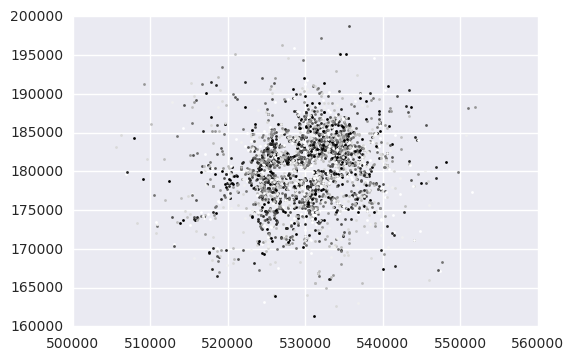

In [43]:
sdf.plot()

_Aaaaaand_ as a final step: let's save our data sample as a brand new shape file that we can open directly in QGIS or ArcGIS:

In [64]:
sdf.to_file(os.path.join('data','airbnb-2016-Feb','listings-summary.shp'))

## Working with PySAL

Now that we've prepared the raw data, we're ready to begin a more substantive analysis using PySAL. Of course, at this stage we're still going to take it fairly easy and not jump feet-first into using concepts like spatial autocorrelation or spatially-aware statistics.

In [29]:
import os
import pysal as ps
import numpy as np
import seaborn as sns
from pylab import *
from pysal.contrib import pdio
from pysal.contrib.viz import mapping as maps

%matplotlib inline

In [4]:
lsoas = ps.open(os.path.join('shapes','LDN-LSOAs.shp'))
print("LSOAs class is: " + str(type(lsoas)))
print("There are " + str(len(lsoas)) + " polygons in the LSOA Shapefile.")
print("Shapefile headers:")
lsoas.header

LSOAs class is: <class 'pysal.core.IOHandlers.pyShpIO.PurePyShpWrapper'>
There are 4835 polygons in the LSOA Shapefile.
Shapefile headers:


{'BBOX Mmax': 0.0,
 'BBOX Mmin': 0.0,
 'BBOX Xmax': 561956.6879999998,
 'BBOX Xmin': 503574.188,
 'BBOX Ymax': 200933.60899994438,
 'BBOX Ymin': 155850.798,
 'BBOX Zmax': 0.0,
 'BBOX Zmin': 0.0,
 'File Code': 9994,
 'File Length': 1423110,
 'Shape Type': 5,
 'Unused0': 0,
 'Unused1': 0,
 'Unused2': 0,
 'Unused3': 0,
 'Unused4': 0,
 'Version': 1000}

In [14]:
listings = ps.open(os.path.join('data','airbnb-2016-Feb','listings-summary.shp'))
print("There are " + str(len(listings)) + " points in the listings summary Shapefile.")
listings.header # See what we loaded

There are 3372 points in the listings summary Shapefile.


{'BBOX Mmax': 0.0,
 'BBOX Mmin': 0.0,
 'BBOX Xmax': 553524.115282029,
 'BBOX Xmin': 505058.782039471,
 'BBOX Ymax': 199220.60939124995,
 'BBOX Ymin': 162303.16860391147,
 'BBOX Zmax': 0.0,
 'BBOX Zmin': 0.0,
 'File Code': 9994,
 'File Length': 47258,
 'Shape Type': 1,
 'Unused0': 0,
 'Unused1': 0,
 'Unused2': 0,
 'Unused3': 0,
 'Unused4': 0,
 'Version': 1000}

### Revisiting Classification

Like pandas/geopandas, PySAL has a classification 'engine' that we can use to bin data based on attribute values. You might wonder why PySAL has its own process when we can already do this within pandas -- there are two reasons: first, now that we've got a shapefile we don't _really_ need to use pandas/geopandas any more and can do our work solely using PySAL; second, PySAL has additional classification methods that are _specific_ to geographic analysis problems. 

The best-known of these is Fisher-Jenks (also sometimes known as 'Natural Breaks'), which groups data into bins based on the sum of squared deviations between classes: in other words, the algorithm iteratively looks for ways to group the data into a specified number of bins such that moving a data point from one group to another would increase the total within-class deviation observed in the data.

But first, let's just go with quantiles and see how you can now work only with PySAL:

In [15]:
# Notice: listingsdata != listings (DBF != Shapefile)
listingsdata = ps.open(os.path.join('data','airbnb-2016-Feb','listings-summary.dbf'))
print("There are " + str(len(listingsdata)) + " rows in the listings summary DBF.")
listingsdata.header # See what we loaded

prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesq5 = ps.Quantiles(prices, k=5) # Classify into 5 quantiles
print(pricesq5) # Show the classification result

There are 3372 rows in the listings summary DBF.
                  Quantiles                  
 
 Lower              Upper               Count
           x[i] <=   40.000               719
  40.000 < x[i] <=   60.000               672
  60.000 < x[i] <=   90.000               693
  90.000 < x[i] <=  136.800               613
 136.800 < x[i] <= 1496.000               675


In [10]:
pricesq5.yb # Check the class assignment

array([0, 3, 4, ..., 3, 0, 4])

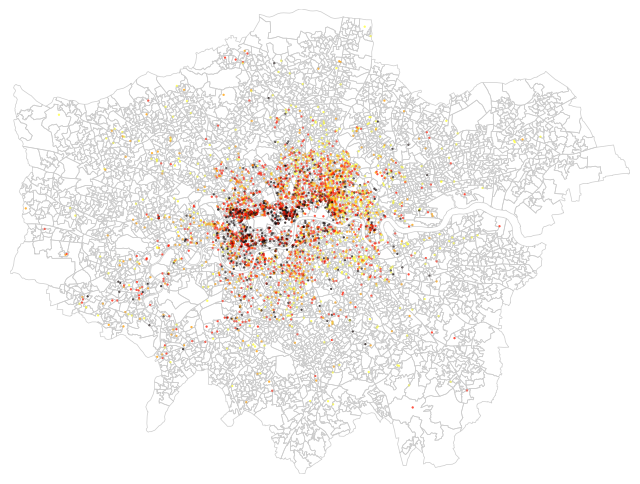

In [27]:
# dir(maps) # If you want to explore this class
# help(maps.map_poly_shp) # And here's how we plot polygons!
fig = figure(figsize=(8,6))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb)
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(2.5, len(listingsdata)))

ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()

Let's unpick the steps involved in this process:

First, we create the figure and specify an output size (this was done in 'inches' [as the screen sees them] but you can specify other units as well such as pixels and cm):
```python
fig = figure(figsize=(8,6)) # Set the output size in 'inches'
```

Next, we create a 'base' map that uses the LSOA polygons loaded from the LDN-LSOA Shapefile:
```python
base = maps.map_poly_shp(lsoas) # Create a polygon map from the LSOA object
base.set_facecolor('none')      # Set the colour of the 'face' (i.e. interior of the polygon)
base.set_linewidth(0.5)         # Set the width of the edge
base.set_edgecolor('0.8')       # Set the colour of the edge (this is a light grey)
```

Now we'll create another map, this one containing the AirBnB points loaded from the listings shapefile that we created earlier:
```python
lyr = maps.map_point_shp(listings) # Create a point map from the AirBnB listings object
lyr = maps.base_choropleth_classif(lyr, pricesq5.yb) # Turn this into a choropleth 
lyr.set_alpha(0.5)                 # Set the transparency (a.k.a. alpha) to 50%
lyr.set_linewidth(0.)              # Set the line width around each point to 0
lyr.set_sizes(np.repeat(2.5, len(listingsdata))) # Set the size of the points to 2.5 (points?)
```

The final step is to add both 'layers' to our figure (so, technically, we could have moved the `fig` line down to here, but it's easier to figure out what's going on if we leave it up above):
```python
ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox]) # Add layer _and_ bounding box
fig.add_axes(ax) # Specify the axes
show() # Done!

```
Notice that you have to set up the x and y axes (`setup_ax`) using two parameters: the first array contains the layer objects created using `maps.map_<type>_shp(...)`, and the second contains the bounding boxes (`bbox`) derived as part of that process. **Note:** you *cannot* find the `bbox` on the object created using `maps...`, it is associated with the original object created using PySAL (`ps.open(...)`).

Another example, this time using Fisher-Jenks. Notice how the results look very, very different and how the boundaries between bins have been radically altered but also capture a bit better our intuition as to how the data can be represented.

In [18]:
prices = np.array(listingsdata.by_col['price']) # Retrieve pricing data
pricesjk = ps.Fisher_Jenks(prices, k=5) # Classify into 5 quantiles
print(pricesjk) # Show the classification result

                 Fisher_Jenks                 
 
 Lower              Upper                Count
           x[i] <=   82.000               1885
  82.000 < x[i] <=  165.000               1057
 165.000 < x[i] <=  308.000                344
 308.000 < x[i] <=  634.000                 80
 634.000 < x[i] <= 1496.000                  6


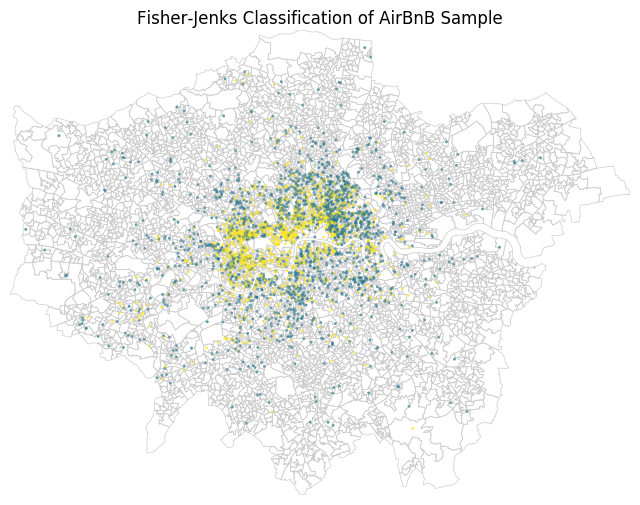

In [28]:
# To find out more about setting colours:
# help(plt.cm)
# help(maps.base_choropleth_classif)

fig = figure(figsize=(8,6))

base = maps.map_poly_shp(lsoas)
base.set_facecolor('none')
base.set_linewidth(0.5)
base.set_edgecolor('0.8')

lyr = maps.map_point_shp(listings)
lyr = maps.base_choropleth_classif(lyr, pricesjk.yb, cmap='viridis')
lyr.set_alpha(0.5)
lyr.set_linewidth(0.)
lyr.set_sizes(np.repeat(4, len(listingsdata)))

plt.title("Fisher-Jenks Classification of AirBnB Sample")
ax = maps.setup_ax([base, lyr], [lsoas.bbox, listings.bbox])
fig.add_axes(ax)
show()

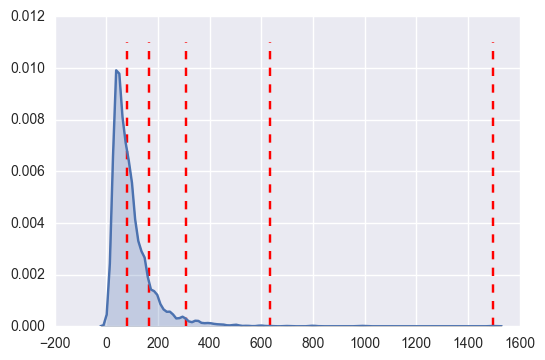

In [39]:
sns.kdeplot(prices, shade=True)
for b in pricesjk.bins:
    plt.vlines(b, 0, 0.011, color='red', linestyle='--')

In [24]:
db = ps.pdio.read_files(os.path.join('shapes','LDN-LSOAs.shp'))
db.info()

There are 4835 polygons in the Shapefile.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 4 columns):
LSOA11CD     4835 non-null object
LSOA11NM     4835 non-null object
LSOA11NMW    4835 non-null object
geometry     4835 non-null object
dtypes: object(4)
memory usage: 151.2+ KB


In [27]:
print("Mean price: " + str(df.price.mean()))
print("Mean number of reviews: " + str(df.number_of_reviews.mean()))

#sb.distplot(df.price)

#sb.distplot(df.number_of_reviews)

#sb.distplot(df.availability_365)

#df.neighbourhood.unique()

Mean price: 96.0800830491
Mean number of reviews: 11.7084977013
